<a href="https://colab.research.google.com/github/vpagonis/EURADOS-2023/blob/main/Code3_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CODE 3.9 CGCD OF MULTIPEAK TL WITH THE TRANSFORMED KV-TL equation

+------+--------+------+------+-------+--------+--------+
| Imax |  Tmax  |  R   |  dR  | E(eV) | dE(eV) | FOM(%) |
+------+--------+------+------+-------+--------+--------+
| 118  | 464.35 | 0.04 | 0.02 | 1.221 |  0.01  |  2.7   |
|  23  | 518.23 | 0.63 | 0.69 | 1.668 |  0.46  |   -    |
+------+--------+------+------+-------+--------+--------+


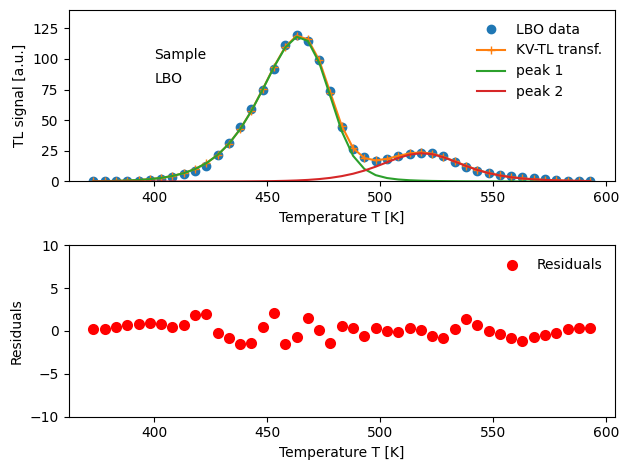

In [ ]:
# Deconvolution using transformed Lambert equation
# ====================================================
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from prettytable import PrettyTable 
from scipy.special import wrightomega
import requests
    

# read data file from GitHub
url='https://github.com/vpagonis/EURADOS-2023/raw/main/lbodata.txt'
response=requests.get(url)
a=response.text
b=np.array(list(map(float,a.strip("[]").split())))
data=b.reshape(-1,2)

x_data,y_data = data[:, 0], data[:, 1] 

kB=8.617E-5     # Boltzmann constant

# Function to evaluate transformed KV-TL equation
def W_func(T,Imax,Tmax,R, E):
    F=kB*(T**2.0)*np.exp(-E/(kB*T))*(1-2*kB*T/E)/E
    Fm=kB*(Tmax**2.0)*np.exp(-E/(kB*Tmax))*(1-2*kB*Tmax/E)/E
    a=kB*Tmax**2.0*(1-1.05*R**1.26)
    Z=R/(1-R)-np.log((1-R)/R)+(F*E*np.exp(E/(kB*Tmax)))/a
    Zm=R/(1-R)-np.log((1-R)/R)+(Fm*E*np.exp(E/(kB*Tmax)))/a
    argW=wrightomega(Z)
    argWm=wrightomega(Zm)
    return Imax*np.exp(-E/(kB*T)*(Tmax-T)/Tmax)*\
    (argWm+argWm**2.0)/(argW+argW**2.0)  

# function to add the components of the TL signals
def total_TL(T, Imax1,Tmax1,R1, E1,Imax2,Tmax2,R2, E2):
    return W_func(T,Imax1,Tmax1,R1, E1)+W_func(T,Imax2,Tmax2,\
	    R2, E2)
    
# find the best fit to the MBO
#  p0= initial values of parameters A, Tmax, R, E for the
# two peaks
params, cov=optimize.curve_fit(total_TL,x_data,y_data,\
p0=(119,463,1e-4,1.1,20,524,1e-4,1.2))

# plot data and the best fit 
plt.subplot(2,1, 1)
plt.plot(x_data,y_data,'o',label='LBO data')
plt.plot(x_data, total_TL(x_data, *params),'+-',\
label='KV-TL transf.')

# plot peaks #1 and #2
plt.plot(x_data, W_func(x_data, *params[0:4]),'-',\
label='peak 1')
plt.plot(x_data, W_func(x_data, *params[4:8]),'-',\
label='peak 2')

leg = plt.legend()
leg.get_frame().set_linewidth(0.0)
plt.ylabel('TL signal [a.u.]')
plt.xlabel(r'Temperature T [K]')
plt.ylim(0,140)
plt.text(400, 100,'Sample')
plt.text(400, 80,'LBO')

# plot residuals
plt.subplot(2,1, 2)
plt.scatter(x_data,total_TL(x_data, *params)
   -y_data,c='r',linewidth=2,label='Residuals')
leg = plt.legend()
leg.get_frame().set_linewidth(0.0)
plt.ylabel('Residuals')
plt.xlabel(r'Temperature T [K]')
plt.ylim(-10,10)
plt.tight_layout()

# find errors of best fit parameters and create table
imax1,Tmax1, R1,E1=int(params[0]),round(params[1],2),\
round(params[2],2),round(params[3],3)
imax2,Tmax2,R2,E2=int(params[4]),round(params[5],2),\
round(params[6],2),round(params[7],3)
beta= 1
dR1 = round(np.sqrt(cov[2][2]),2)
dE1 = round(np.sqrt(cov[3][3]),2)
dR2 = round(np.sqrt(cov[6][6]),2)
dE2 = round(np.sqrt(cov[7][7]),2)

# find FOM 
res=total_TL(x_data, *params)-y_data
FOM=round(100*np.sum(abs(res))/np.sum(y_data),2)

# print the Table of parameters and errors for the 2 peaks
myTable = PrettyTable(["Imax", "Tmax","R", "dR","E(eV)",\
"dE(eV)","FOM(%)"]) 
myTable.add_row([imax1,Tmax1,R1,dR1,E1,dE1,FOM])
myTable.add_row([imax2,Tmax2,R2,dR2,E2,dE2,"-"])
print(myTable)
plt.show()

# [Return to EURADOS website](https://blog.mcdaniel.edu/vasilispagonis/python-codes-for-eurados-2023/)